# 变分量子奇异值分解

变分量子奇异值分解（Variational Quantum Singular Value Decomposition，VQSVD）是使用量子线路实现矩阵SVD分解，复现论文 [1] 内容。

文中给出的 VASVD 算法流程如下：

![](images/vqsvd_algorithm.png)

其流程图如下：

![](images/vqsvd_diagram.png)

## Ansatz线路

论文中给出4种线路结构，如下图所示，如果所分解的矩阵全是实数，则取 $U = R_y(\alpha_j)$，如果包含复数则取 $R_z(\theta_j)R_y(\phi_j)R_z(\psi_j)$。可根据图中给出的结构重复多次得到不同线路，由于实验线路大部分使用3-bit，因此主要除了(a)之外的线路只考虑3-bit情形。代码实现见函数 `get_ansatz`。

![](images/ansatz_type.png)

```python
def get_ansatz(n_qubit: int, depth: int, kind='a') -> Circuit:
    """Get ansatz circuit.

    Args:
        n_qubit: number of qubit used.
        depth: number of block repetation.
        kind: circuit type, optional value: {'a', 'b', 'c', 'd'}.

    Return:
        Two ansatz circuits with different parameter names.
    """
    ansatz = Circuit()

    if kind == 'a':
        for layer in range(depth+1):
            for i in range(n_qubit):
                ansatz += RY(f'{layer * n_qubit + i + 1}').on(i)
            for i in range(n_qubit - 1):
                ansatz += CNOT(i+1, i)
    elif kind == 'b':
        assert n_qubit == 3, "this circuit only support n_qubit = 3"
        for layer in range(depth+1):
            ansatz += Circuit([
                RY(f'{8 * layer + 0}').on(0),
                RY(f'{8 * layer + 1}').on(1),
                CNOT(1, 0),
                RY(f'{8 * layer + 2}').on(0),
                RY(f'{8 * layer + 3}').on(1),
                RY(f'{8 * layer + 4}').on(1),
                RY(f'{8 * layer + 5}').on(2),
                CNOT(2, 1),
                RY(f'{8 * layer + 6}').on(1),
                RY(f'{8 * layer + 7}').on(2)
            ])
    elif kind == 'c':
        assert n_qubit == 3, "this circuit only support n_qubit = 3"
        for layer in range(depth+1):
            ansatz += Circuit([
                RY(f'{3 * layer + 0}').on(0),
                RY(f'{3 * layer + 1}').on(1),
                RY(f'{3 * layer + 2}').on(2),
                CNOT(1, 0),
                CNOT(2, 1),
                CNOT(0, 2)
            ])
    elif kind == 'd':
        for layer in range(depth+1):
            ansatz += Circuit([
                RY(f'{6 * layer + 0}').on(0),
                RY(f'{6 * layer + 1}').on(1),
                RY(f'{6 * layer + 2}').on(2),
                CNOT(1, 0),
                CNOT(2, 1),
                RY(f'{6 * layer + 0}').on(0),
                RY(f'{6 * layer + 1}').on(1),
                RY(f'{6 * layer + 2}').on(2),
                CNOT(0, 2),
                CNOT(1, 2)
            ])
    else:
        assert kind in {'a', 'b', 'c', 'd'}, \
            "Parameter kind should be one of {'a', 'b', 'c', 'd'}"

    ansatz_u = add_prefix(ansatz, 'alpha')
    ansatz_v = add_prefix(ansatz, 'beta')
    return (ansatz_u, ansatz_v)
```

## 矩阵分解

实验中需要对非厄米的矩阵分解，即 $M = \sum_{k=1}^K c_k A_k$，其中 $A_k$ 是厄米矩阵，下面实现的 $A_k$ 为 X, Y或Z门对应矩阵的张量积。任何一个矩阵都可以分解成 Pauli 基张量积，例如对 $16\times 16$ 的矩阵，可分解成

$$
M = \frac{1}{16}\sum_{i,j,k,l} h_{ijkl} \sigma_i\otimes\sigma_j\otimes\sigma_k\otimes\sigma_l
$$

其中 $i,j,k,l\in\{0, 1, 2, 3\}$，

$$
h_{ijkl} = Tr((\sigma_i\otimes\sigma_j\otimes\sigma_k\otimes\sigma_l)^\dagger \cdot M)
$$

$\sigma_0, \sigma_1, \sigma_2, \sigma_3$ 分别对应 $I, X, Y, Z$ 矩阵。

推广到大小为 $N = 2^n$ 的 $N\times N$ 的矩阵，其中 $n$ 为量子比特数，则有

$$
M = \frac{1}{N} \sum_J Tr(\tilde{\sigma_J} H)\tilde{\sigma_J}
$$

其中，

$$
\tilde{\sigma_J} = \prod_{k=1}^n \tilde{\sigma_{J_k}}^{(k)}
$$

$J\in \{0, 1, 2, 3\}^n$ 是一个包含 $n$ 个整数的元组，$J_i\in \{0, 1, 2, 3\}$， $\tilde{\sigma} = (I, X, Y, Z)$。

针对输入的矩阵，分解过程实现代码如下：

```python
def decompose_matrix(n_qubit: int, in_mat: np.ndarray) -> List[tuple]:
    """Decompose a arbitrary matrix with the linear combination of tensor
    product of pauli operators {X, Y, Z, I}.

    Args:
        n_qubit: number of qubit.
        in_mat: input matrix that will be decompose.

    Return:
        List((coef, mat)): `mat` is tensor product of pauli operator and `coef`
            is corresponding coefficient.
    """
    def hs_product(m1, m2):
        """Hilbert-Schmidt-Product of two matrices `m1`, `m2`"""
        return (np.dot(m1.conjugate().transpose(), m2)).trace()

    def krons(arrs):
        """Get kron product of matrix array."""
        res = arrs[0]
        for a in arrs[1:]:
            res = np.kron(res, a)
        return res

    sx = np.array([[0, 1], [1, 0]], dtype=np.complex128)
    sy = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0], [0, -1]], dtype=np.complex128)
    ey = np.array([[1, 0], [0, 1]], dtype=np.complex128)
    op_list = np.array([sx, sy, sz, ey])

    # All combination of pauli gates on circuit.
    items = list(it.product([0, 1, 2, 3], repeat=n_qubit))

    result = []
    for item in items:
        mat = krons(op_list[list(item)])
        coef = hs_product(mat, in_mat) / (2**n_qubit)
        result.append((coef, mat))
    return result
```

## 选择基矢量

算法步骤中的基的选择比较简单，例如对3-bit，直接产生 $|000\ket, |001\ket, |010\ket\cdots$ 这样的8个基矢量即可，如果所需阶数`rank`小于 8，任取其中几个即可。代码实现如下：

```python
def get_basis(n_qubit: int, rank=5) -> List:
    """Get basis which are orthonormal each other and encoded with circuit.
    Here just return $|0...00\rangle$, $|0...01\rangle$ ... in turn until
    `rank` basis.

    Args:
        n_qubit: number of qubit used.
        rank: number of basis.

    Return:
        Basis encoded with circuit.
    """
    basis = []
    for k, ps in enumerate(it.product([0, 1], repeat=n_qubit)):
        if k >= rank:
            break
        cir = Circuit()
        for i, p in enumerate(ps):
            if p == 1:
                cir += X.on(i)
        basis.append(cir)
    return basis
```

## 训练

训练过程按照论文的方式，计算损失 $L(\alpha,\beta)$，然后使用优化器更新参数即可，很多优化器需要传输各个参数的梯度值，如果没有获得整个函数梯度的接口，可根据线性关系将各组分梯度按系数加权即可得到总体参数的梯度。这里使用Mindspore提供的Adam优化器更新参数，其中为了最大化损失值，将梯度取相反数。训练的关键代码如下：

```python
    def train_one_loop(self):
        """Iterating over the basis and update the weight."""
        expect = 0.0
        for i, (cir_left, cir_right) in enumerate(\
                zip(self.circuits_left, self.circuits_right)):
            grad = np.zeros_like(self.weight, dtype=np.complex128)
            fval = 0.0

            for (coef, mat) in self.mat_item:
                ham = Hamiltonian(sparse.csr_matrix(mat))
                ops = self.sim.get_expectation_with_grad(ham, cir_right, cir_left)
                f, g = ops(self.weight)
                fval += coef * f[0][0].conj()
                grad += coef * g[0][0].conj()
            # Update weight
            weighted_grad = self.q[i] * grad.real
            self.update_weight(weighted_grad)
            expect += self.q[i] * fval.real
        return expect

    def update_weight(self, grad):
        """Update weight."""
        if self.method == 'adam':
            grad = -grad
            grad = ms.Tensor(grad, dtype=ms.float64)
            self.optimizer((grad,))
            self.weight = self.optimizer.parameters[0].asnumpy()
        else:
            self.weight += self.lr * grad
```

补充：整个网络的训练也可以通过`scipy.minimize`的一些优化函数接口实现。

将相关接口封装，其中 `decompose_matrix` 实现将输入矩阵分解成算法步骤1中 $M = \sum_{k=1}^K c_k A_k$ 形式，`get_basis` 返回步骤3中的基（Computational basis），`reconstruct_by_vqsvd` 传入相关参数，重建矩阵。`VQSVDTrainer` 封装参数训练过程。下面对主体函数 `run` 进行讲解，更多细节可查看 `src/` 目录下源代码。

In [1]:
import numpy as np
from src.uitls import decompose_matrix, get_basis, reconstruct_by_vqsvd
from src.vqsvd import VQSVDTrainer


def run_demo(n_qubit, rank, ansatz_uv, in_mat, epoch=50, lr=1e-2, method='adam'):
    """Run QVSVD process with specific parameters.

    Args:
        n_qubit: number of qubit.
        rank: rank T.
        ansatz_uv: U and V ansatz circuits.
        in_mat: the input matrix.
        epoch: the epoch of training.
        lr: learning rate of optimizer.

    Return:
        re_mat: the reconstructed matrix.
    """
    # 分解矩阵
    mat_item = decompose_matrix(n_qubit, in_mat)
    # 变分线路U和V
    ansatz_u, ansatz_v = ansatz_uv
    # Algorithm 1中步骤2的正数q
    q = np.arange(rank, 0, -1)
    # 正交基底
    basis = get_basis(n_qubit, rank)
    # 封装的训练器
    vqsvd = VQSVDTrainer(n_qubit, mat_item, rank, ansatz_u, ansatz_v, q, basis,
                         lr=lr, method=method)
    # 训练参数
    vqsvd.train(epoch)
    # 重建矩阵
    re_mat = reconstruct_by_vqsvd(n_qubit, in_mat, basis, ansatz_u, ansatz_v,
                                  weight=vqsvd.weight)
    return re_mat

下面以重建一个 `8 x 8` 的矩阵为例，说明函数使用。

100%|██████████| 200/200 [01:53<00:00,  1.76it/s]


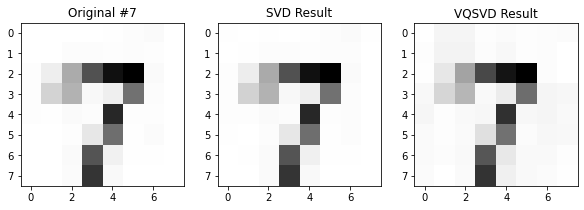

In [11]:
import matplotlib.pyplot as plt
from src.uitls import reconstruct_by_svd, get_ansatz


def demo():
    n_qubit = 3           # 量子比特数
    depth = 20            # 线路深度
    rank = 5              # 使用的秩数
    max_epoch = 200       # 最大迭代次数
    lr = 0.01             # 学习率
    # 读取图片，大小为 8x8
    in_mat = plt.imread('images/digit7_8x8.png')

    # 使用经典 SVD 重建图片
    re_mat_svd = reconstruct_by_svd(in_mat, rank)
    # 使用 VQSVD 重建图片
    ansatz_uv = get_ansatz(n_qubit, depth)
    re_mat = run_demo(n_qubit, rank, ansatz_uv, in_mat,
                      epoch=max_epoch, lr=lr)
    # 绘图
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(in_mat, cmap='gray')
    plt.title("Original #7")
    plt.subplot(1, 3, 2)
    plt.imshow(re_mat_svd, cmap='gray')
    plt.title("SVD Result")
    plt.subplot(1, 3, 3)
    plt.imshow(re_mat, cmap='gray')
    plt.title("VQSVD Result")
    plt.show()


demo()

## 论文图片复现

论文中其他图像复现代码如下：

In [ ]:
from src.demo import plot_figure4
# from src.demo import plot_figure5, plot_figure7, plot_figure7_light


# 复现论文图4
plot_figure4()

- 运行 `plot_figure4()`，论文 Fig.4 复现结果如下：

![](images/figure4_bak.png)



- 运行 `plot_figure5(n_qubit=3)`, 使用 VQSVD 重建 `8 x 8` 矩阵，在 8u32G cpu 耗时大约 6 分钟。如果运行 `plot_figure5(n_qubit=5)` 则重建 `32 x 32` 矩阵，此时可能比较耗时，在 8u32G cpu 耗时大约 3 个小时。运行 `plot_figure5(n_qubit=3)` 结果如下，可以看到此时 VQSVD 能很好重建原图像。

![](images/figure5_8x8_bak.png)

- 运行 `plot_figure7_light()`，复现结果如下图，可见相同参数数目下线路 (a) 效果最好。`plot_figure7_light` 采用 scipy 的 BFGS 优化器优化，`plot_figure7` 使用 mindspore 的 Adam 优化器优化，前者收敛速度更快。

![](images/figure7_bak.png)


## 其他改进

复现论文中 Figure.5 结果，图片大小为 `32x32` 时速度较慢，通过使用 BFGS 优化器加快收敛，另外通过获取量子态直接计算期望值，而不是通过将矩阵分解成哈密顿量再逐项计算，可以有效提高计算速度。需要说明的是，使用量子态直接计算期望值是仅在模拟器中演示算法总体可行性，现实中无法获得量子真实状态。通过改进，算法速度提高 6 倍左右，使用方法为 `plot_figure5_light`，其底层通过 `scipy.optimize.minimize` 封装，具体内容见函数 `utils.run_light`。

In [ ]:
from src.demo import plot_figure5_light


plot_figure5_light()

复现结果如下，可见 VQSVD 成功重建图像。

![](images/figure5_bak.png)

## 参考文献

[1] Wang, X., Song, Z., & Wang, Y. (2021). Variational Quantum Singular Value Decomposition. Quantum, 5, 483.